In [7]:
from src.analyzer import Analyzer
from src.metrics import pairwise_bce_of_group, cbc_of_group, scs_of_group, rbc_of_group
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import json


In [8]:
# Load temperature logprobs data
temp_data = pd.read_csv("data/temperature_logprobs.csv")
print(f"Loaded temperature data: {temp_data.shape}")
print(f"Temperature values: {sorted(temp_data['temperature'].unique())}")
print(f"Models: {temp_data['model_name'].unique()}")

# Create analyzer
temp_analyzer = Analyzer(temp_data)

# Add temperature as a numeric column for analysis
temp_analyzer.add_column(
    column_name="Temperature",
    column_spec=lambda df: df["temperature"].astype(float)
)

print(f"Data shape: {temp_analyzer.df.shape}")
temp_analyzer.df.head()


Loaded temperature data: (19380, 31)
Temperature values: [np.float64(0.01), np.float64(0.0316227766016837), np.float64(0.1), np.float64(0.3162277660168379), np.float64(1.0), np.float64(2.0)]
Models: ['openai-community/gpt2']
Data shape: (19380, 32)


,item_index,class_category,class,class_elicitation,evidence_text,evidence_elicitation,conversation_history,model_name,model_provider,temperature,...,prior_prompt,likelihood_prompt,posterior_prompt,prior_full_text,likelihood_full_text,posterior_full_text,prior_token_logprobs,likelihood_token_logprobs,posterior_token_logprobs,Temperature
0,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,a record-tying number of world championships ...,I am most impressed by,We've been analyzing famous athletes and how t...,openai-community/gpt2,hf,0.01,...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-69.837890625, 0.0, -37.71533203125]","[-317.990234375, -507.4521484375, -23.765625, ...","[-112.1767578125, 0.0, -45.04296875]",0.01
1,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,breathtaking qualifying laps and legendary we...,I am most impressed by,We've been analyzing famous athletes and how t...,openai-community/gpt2,hf,0.01,...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-69.837890625, 0.0, -37.71533203125]","[-1252.7607421875, -665.7646484375, -535.47265...","[-75.310546875, 0.0, -51.98095703125]",0.01
2,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,strategic championship battles with rivals ac...,I am most impressed by,We've been analyzing famous athletes and how t...,openai-community/gpt2,hf,0.01,...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-69.837890625, 0.0, -37.71533203125]","[-1240.0380859375, -792.021484375, -356.973022...","[-113.146484375, 0.0, -55.70751953125]",0.01
3,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,dominant performances in the turbo-hybrid era.,I am most impressed by,We've been analyzing famous athletes and how t...,openai-community/gpt2,hf,0.01,...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-69.837890625, 0.0, -37.71533203125]","[-1252.611328125, -4.262238025665283, -98.1719...","[-90.169921875, 0.0, -39.150390625]",0.01
4,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,the youngest ever Formula 1 world champion.,I am most impressed by,We've been analyzing famous athletes and how t...,openai-community/gpt2,hf,0.01,...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-69.837890625, 0.0, -37.71533203125]","[-62.111328125, -877.369140625, -287.958984375...","[-124.2392578125, 0.0, 0.0]",0.01


In [9]:
# Define coherence metrics to calculate (only BCE and BCC)
metrics_config = [
    {"name": "BCE", "func": pairwise_bce_of_group, "kwargs": {"square": True}, "display_name": "BCE"},
    {"name": "BCC", "func": cbc_of_group, "kwargs": {}, "display_name": "BCC"}
]

# Calculate all metrics using the same grouping structure as in scaling_plots
analyzers = {}
group_by_cols = [
    "evidence_text",
    "class_category", 
    "Temperature",
    "model_name",
    "conversation_history"
]

for metric_config in metrics_config:
    print(f"Calculating {metric_config['name']}...")
    analyzer = temp_analyzer.calculate_metric(
        metric_name=metric_config["display_name"],
        metric_func=metric_config["func"],
        group_by_cols=group_by_cols,
        log_prior_col="prior_logprob",
        log_likelihood_col="likelihood_logprob", 
        log_posterior_col="posterior_logprob",
        inherit_identical_values=True,
        **metric_config["kwargs"]
    )
    analyzers[metric_config["name"]] = analyzer
    print(f"  Result shape: {analyzer.df.shape}")

print("\nAll metrics calculated successfully!")


Calculating BCE...
  Result shape: (38760, 17)
Calculating BCC...
  Result shape: (3876, 17)

All metrics calculated successfully!


In [10]:
# Calculate mean values for each metric across temperatures
mean_analyzers = {}

for metric_config in metrics_config:
    name = metric_config["name"]
    display_name = metric_config["display_name"]
    
    mean_analyzer = analyzers[name].calculate_metric(
        metric_func="mean",
        group_by_cols=["Temperature", "class_category"],
        metric_col=display_name,
        metric_name=f"Mean {display_name}",
        inherit_identical_values=True,
    )
    
    mean_analyzers[name] = mean_analyzer
    print(f"{name} mean calculation complete: {mean_analyzer.df.shape}")

# Also calculate overall means (not by category)
overall_mean_analyzers = {}

for metric_config in metrics_config:
    name = metric_config["name"]
    display_name = metric_config["display_name"]
    
    overall_mean_analyzer = analyzers[name].calculate_metric(
        metric_func="mean",
        group_by_cols=["Temperature"],
        metric_col=display_name,
        metric_name=f"Mean {display_name}",
        inherit_identical_values=True,
    )
    
    overall_mean_analyzers[name] = overall_mean_analyzer

# Also calculate counts for each temperature point
overall_count_analyzers = {}

for metric_config in metrics_config:
    name = metric_config["name"]
    display_name = metric_config["display_name"]
    
    overall_count_analyzer = analyzers[name].calculate_metric(
        metric_func="count",
        group_by_cols=["Temperature"],
        metric_col=display_name,
        metric_name=f"Count {display_name}",
        inherit_identical_values=True,
    )
    
    overall_count_analyzers[name] = overall_count_analyzer

print("\nMean and count calculations completed!")


BCE mean calculation complete: (60, 12)
BCC mean calculation complete: (60, 12)

Mean and count calculations completed!


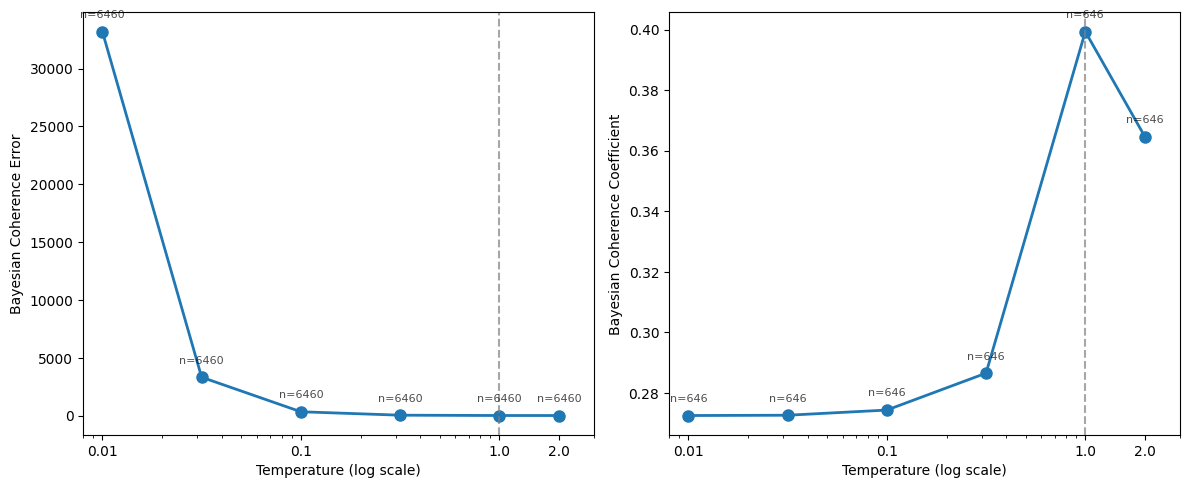

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create temperature invariance plots for BCE and BCC
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define full names for y-axis labels
full_names = {
    "BCE": "Bayesian Coherence Error",
    "BCC": "Bayesian Coherence Coefficient"
}

for i, metric_config in enumerate(metrics_config):
    name = metric_config["name"]
    display_name = metric_config["display_name"]
    ax = axes[i]
    
    # Get data for this metric
    data = overall_mean_analyzers[name].df
    count_data = overall_count_analyzers[name].df
    
    temp_values = data["Temperature"].values
    metric_values = data[f"Mean {display_name}"].values
    count_values = count_data[f"Count {display_name}"].values
    
    # Plot main line
    ax.semilogx(temp_values, metric_values, 'o-', linewidth=2, markersize=8, label=f'{name}')
    
    # Add count annotations for each point
    for temp, metric, count in zip(temp_values, metric_values, count_values):
        ax.annotate(f'n={int(count)}', (temp, metric), 
                   textcoords="offset points", xytext=(0,10), ha='center', 
                   fontsize=8, alpha=0.7)
    
    # Add vertical line at temperature = 1.0 (baseline)
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Temperature (log scale)')
    ax.set_ylabel(full_names[name])
    # No subplot titles or legend as requested
    
    # Set x-axis limits and ticks
    ax.set_xlim(8e-3, 3)
    ax.set_xticks([1e-2, 1e-1, 1e0, 2])
    ax.set_xticklabels(['0.01', '0.1', '1.0', '2.0'])

plt.tight_layout()
plt.savefig('results/plots/temperature_invariance_plots.png')
plt.show()


=== Category Breakdown Analysis ===
Available categories: ['airlines', 'architectural_styles', 'culinary_techniques', 'financial_strategies', 'formula_1_drivers', 'school_of_philosophy', 'state_of_mind', 'superheroes', 'tech_innovators', 'writing_style']


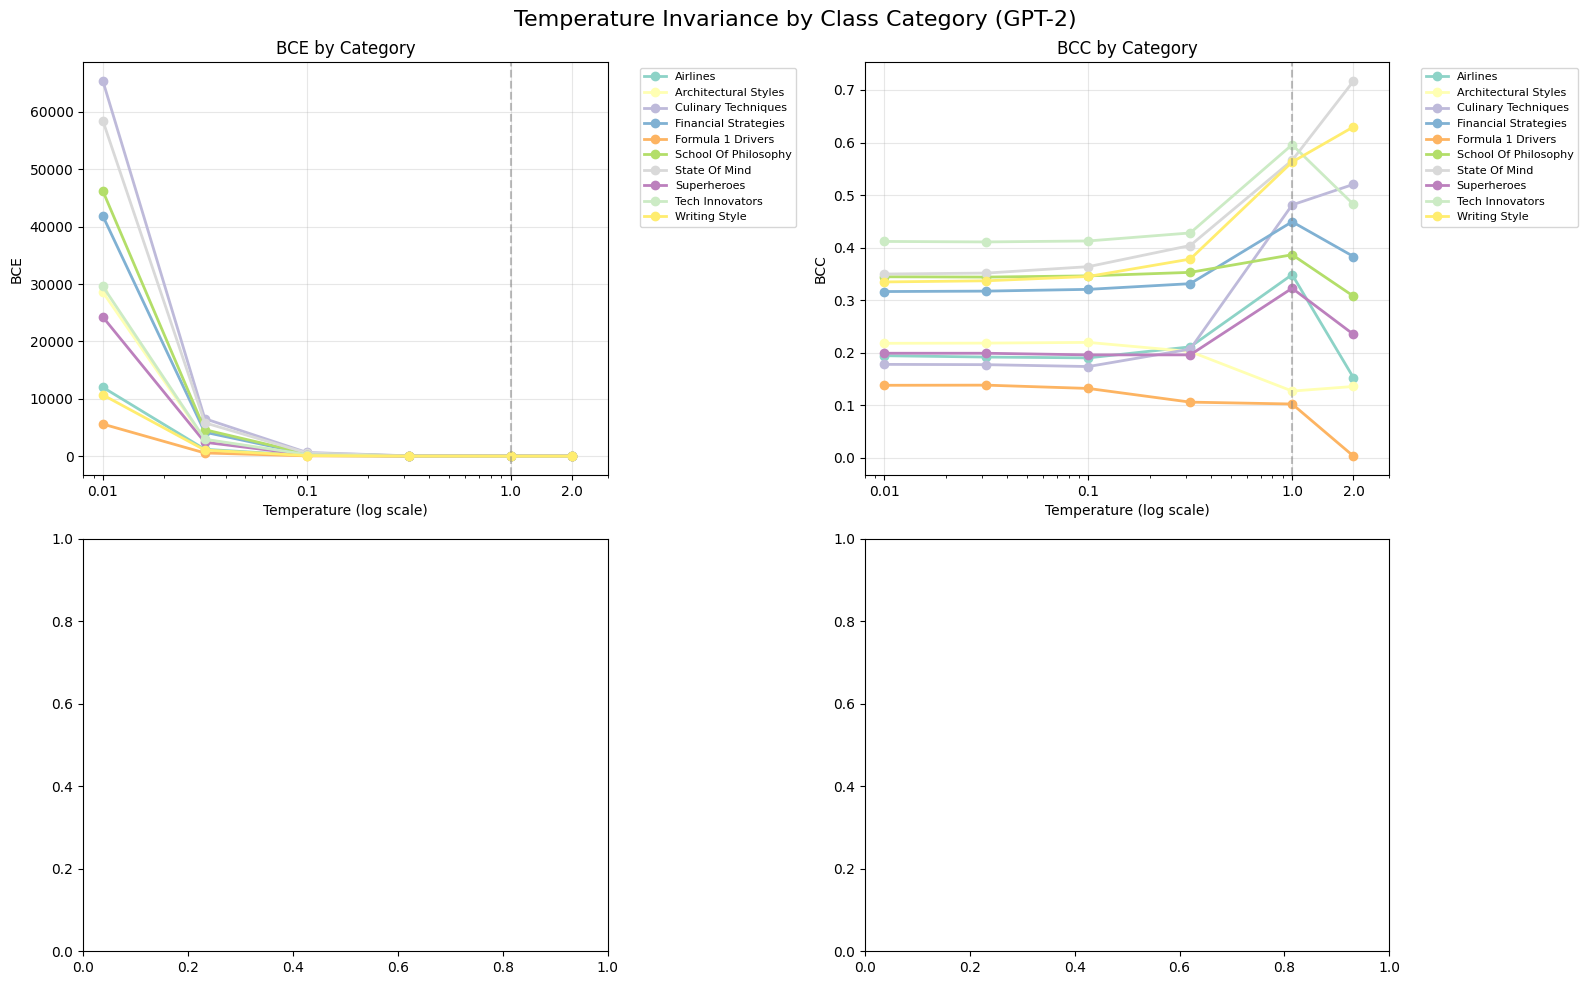

In [12]:
# Category breakdown analysis
print("=== Category Breakdown Analysis ===")
print("Available categories:", sorted(mean_analyzers["BCE"].df["class_category"].unique()))

# Create category breakdown plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Temperature Invariance by Class Category (GPT-2)', fontsize=16)

axes = axes.flatten()
categories = sorted(temp_analyzer.df["class_category"].unique())
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

for i, metric_config in enumerate(metrics_config):
    name = metric_config["name"]
    display_name = metric_config["display_name"]
    ax = axes[i]
    
    # Plot each category
    for cat, color in zip(categories, colors):
        cat_data = mean_analyzers[name].df[mean_analyzers[name].df["class_category"] == cat]
        if len(cat_data) > 0:
            temp_values = cat_data["Temperature"].values
            metric_values = cat_data[f"Mean {display_name}"].values
            
            ax.semilogx(temp_values, metric_values, 'o-', 
                       color=color, label=cat.replace('_', ' ').title(), 
                       linewidth=2, markersize=6)
    
    # Add baseline temperature line
    ax.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Formatting
    ax.set_xlabel('Temperature (log scale)')
    ax.set_ylabel(f'{name}')
    ax.set_title(f'{name} by Category')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Set x-axis limits and ticks
    ax.set_xlim(8e-3, 3)
    ax.set_xticks([1e-2, 1e-1, 1e0, 2])
    ax.set_xticklabels(['0.01', '0.1', '1.0', '2.0'])

plt.tight_layout()
plt.show()
